In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')   # Suppress MatPlot lib warnings
tf.get_logger().setLevel('ERROR')   # Suppress TensorFlow logging (2)

## Load Model and Labels

In [12]:
PATH_TO_LABELS = "./TensorFlow/workspace/head_detector/annotations/label_map.pbtxt"
PATH_TO_SAVED_MODEL = "./TensorFlow/workspace/head_detector/exported-models/head_detector/saved_model/"

In [13]:
print('Loading model...', end='')
start_time = time.time()
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 8.427545070648193 seconds


In [14]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Test Detection Visibly

In [15]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image
      show_plot: whether or not to create a plot of the detections
      detect_threshold: min detection threshold
      print_info: whether or not to print logging of what is happening in this function

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def detect_heads_in_image(image_path, show_plot=False, detect_threshold=.30, print_info=False):
  if print_info: 
    print('Running inference for {} ... '.format(image_path), end='')
  image_np = load_image_into_numpy_array(image_path)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image_np)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis, ...]
  # input_tensor = np.expand_dims(image_np, 0)
  detections = detect_fn(input_tensor)
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
  detections['num_detections'] = num_detections
  # detection_classes should be ints.
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
  image_np_with_detections = image_np.copy()

  if show_plot:
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=detect_threshold,
          agnostic_mode=False)
    plt.figure()
    plt.imshow(image_np_with_detections)

  number_above_threshold = 0
  for score in detections['detection_scores']:
      if score > detect_threshold:
        number_above_threshold += 1

  if print_info:
    print(f'Done: Found {number_above_threshold} heads')
  return number_above_threshold


Running inference for ./TensorFlow/workspace/head_detector/images/train/2023_07_18__09_06.jpg ... Done: Found 1 heads
Running inference for ./TensorFlow/workspace/head_detector/images/train/2023_07_18__14_43.jpg ... Done: Found 6 heads
Running inference for ./TensorFlow/workspace/head_detector/images/train/2023_07_19__17_40.jpg ... Done: Found 4 heads


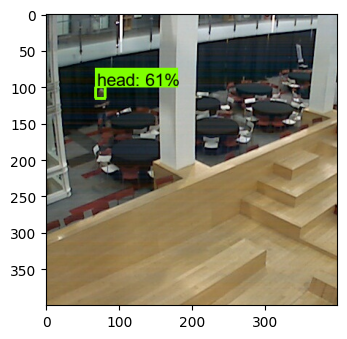

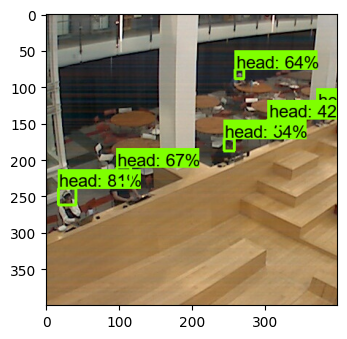

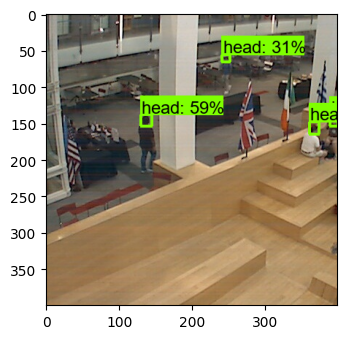

In [16]:
# run inference on these images
IMAGE_PATHS = [
    "./TensorFlow/workspace/head_detector/images/train/2023_07_18__09_06.jpg",
    "./TensorFlow/workspace/head_detector/images/train/2023_07_18__14_43.jpg",
    "./TensorFlow/workspace/head_detector/images/train/2023_07_19__17_40.jpg",
    ]

for image_path in IMAGE_PATHS:
  detect_heads_in_image(image_path, show_plot=True, print_info=True)
   
plt.show()

## Parse frame data into date and head counts

In [17]:
from datetime import datetime

"""
Given some filename, parse the date out of the file name. This
function assumes that the filename is produced by the scraper script,
so the name should be in the format "%Y_%m_%d__%H_%M.jpg"
"""
def parse_frame_filename_to_date(filename):
    return datetime.strptime(filename, "%Y_%m_%d__%H_%M.jpg")

"""
Given the name and directory of an image file, detect the number of heads in the image
and the date it was taken at.
"""
def parse_frame_into_complete_record(filedir, filename):
    filepath = os.path.join(filedir, filename)
    return {
        "date": parse_frame_filename_to_date(filename),
        "num_heads": detect_heads_in_image(filepath, detect_threshold=.5),
        "full_path": filepath
    }

In [18]:
from os import listdir
from os.path import isfile, join
import pandas as pd

# the scraper script dumps the frames it scrapes into this folder, so we want to analyze all the files in this folder
images_dir = './frames/'
image_files = [parse_frame_into_complete_record(images_dir, filename) for filename in listdir(images_dir) if isfile(join(images_dir, filename))]
image_df = pd.DataFrame(image_files)
image_df.head()

,date,num_heads,full_path
0,2023-07-17 17:34:00,2,./frames/2023_07_17__17_34.jpg
1,2023-07-17 17:44:00,1,./frames/2023_07_17__17_44.jpg
2,2023-07-17 17:55:00,1,./frames/2023_07_17__17_55.jpg
3,2023-07-17 18:05:00,1,./frames/2023_07_17__18_05.jpg
4,2023-07-17 18:15:00,2,./frames/2023_07_17__18_15.jpg


## Plots 
See `./README.md` for interpretations!

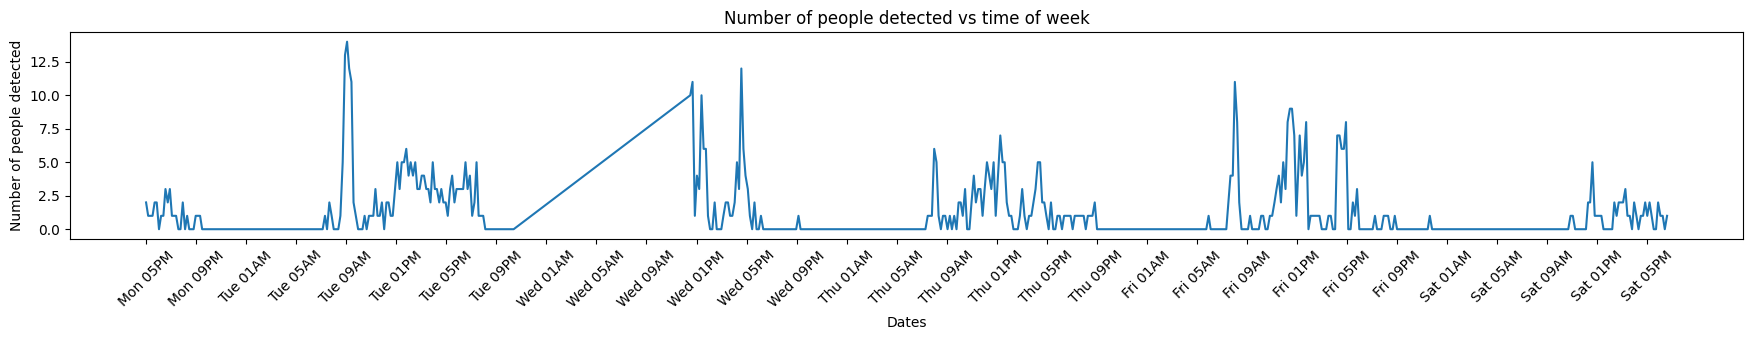

In [19]:

import matplotlib.pyplot as plt
import matplotlib
from datetime import timedelta
  
# plot a line graph for the # of heads detected at which times
plt.rcParams["figure.figsize"] = [17.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
plt.plot_date(image_df["date"], image_df["num_heads"], linestyle='-', fmt="")
plt.xlabel("Dates")
plt.ylabel("Number of people detected")
plt.title("Number of people detected vs time of week")
plt.xticks(np.arange(min(image_df["date"]), max(image_df["date"]), timedelta(hours=4)), rotation=45)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%a %I%p'))
plt.show()



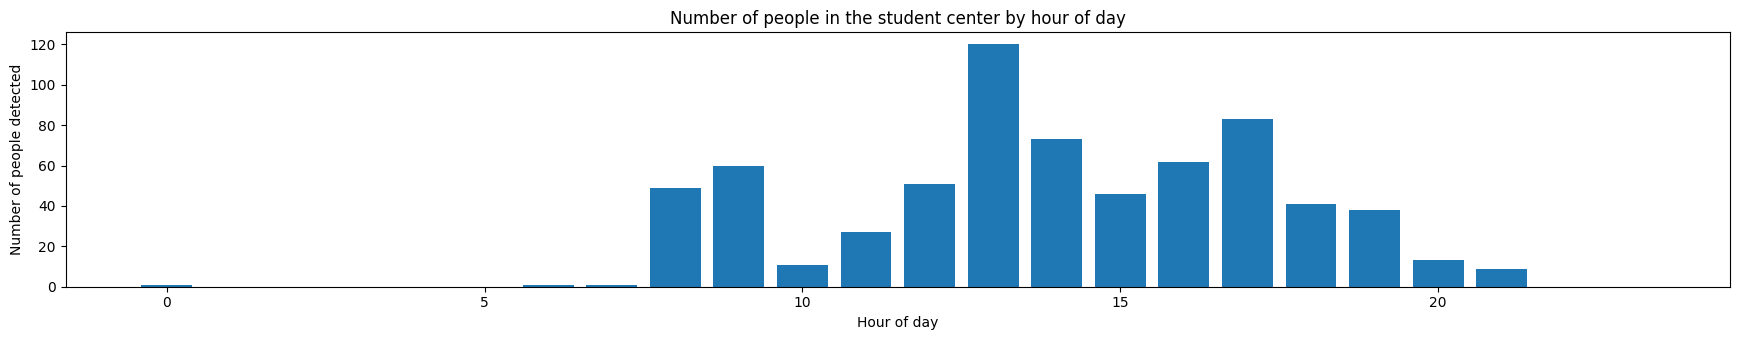

In [20]:
# plot a bar chart for the number of heads detected per hour of the day

# group by the hour of day
image_df_hourly_grouping = image_df.groupby(image_df.date.map(lambda d: d.hour)).sum()

# make the bar chart
plt.bar(image_df_hourly_grouping.index, image_df_hourly_grouping.num_heads)
plt.xlabel("Hour of day")
plt.ylabel("Number of people detected")
plt.title("Number of people in the student center by hour of day")
plt.show()